Prédire la qualité de l’air (AQI Value) à partir des moyennes (Avg) des polluants.

In [34]:
pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


1. Préparation des Données: 


- Charger et parser le fichier XML
- Créer un DataFrame

In [35]:
#Importer les librairies nécessaires
import pandas as pd
import xml.etree.ElementTree as ET

In [36]:
def xml_to_dataframe(xml_file):

    # Charger et parser le fichier
    tree = ET.parse(xml_file)  # adapte le nom du fichier
    root = tree.getroot()

    data = []
    # Explorer tous les éléments station

    for country in root.findall('.//Country'):
        for state in country.findall('.//State'):
            state_name = state.attrib.get('id', None)  
            for city in state.findall('.//City'):
                city_name = city.attrib.get('id', None)
                for station in city.findall('.//Station'):
                    station_name = station.attrib.get('id', None)
                    latitude = station.attrib.get('latitude', None)
                    longitude = station.attrib.get('longitude', None)
                    
                    station_data = {
                        'Country': country.attrib.get('id', None),  
                        'State': state_name,                       
                        'City': city_name,
                        'Station': station_name,
                        'Latitude': latitude,
                        'Longitude': longitude
                    }

                    # Polluants
                    for pollutant in station.findall('Pollutant_Index'):
                        pol_name = pollutant.attrib['id']
                        avg = pollutant.attrib['Avg']
                        station_data[f"{pol_name}_Avg"] = float(avg) if avg != "NA" else None

                    # AQI
                    aqi = station.find('Air_Quality_Index')
                    if aqi is not None:
                        station_data['AQI'] = int(aqi.attrib['Value'])
                        station_data['Predominant_Pollutant'] = aqi.attrib['Predominant_Parameter']
                        data.append(station_data)


    # Créer le DataFrame
    df = pd.DataFrame(data)
    return df

In [37]:
df = xml_to_dataframe('data_aqi_cpcb.xml')

#afficher le DataFrame
df.head()

,Country,State,City,Station,Latitude,Longitude,PM2.5_Avg,PM10_Avg,NO2_Avg,NH3_Avg,SO2_Avg,CO_Avg,OZONE_Avg,AQI,Predominant_Pollutant
0,India,Andhra_Pradesh,Anantapur,"Gulzarpet, Anantapur - APPCB",14.675886,77.593027,24.0,24.0,23.0,3.0,7.0,29.0,25.0,29,CO
1,India,Andhra_Pradesh,Chittoor,"Gangineni Cheruvu, Chittoor - APPCB",13.204880,79.097889,19.0,22.0,14.0,2.0,9.0,4.0,35.0,35,OZONE
2,India,Andhra_Pradesh,Kadapa,"Yerramukkapalli, Kadapa - APPCB",14.465052,78.824187,37.0,32.0,30.0,1.0,2.0,21.0,21.0,37,PM2.5
3,India,Andhra_Pradesh,Rajamahendravaram,"Anand Kala Kshetram, Rajamahendravaram - APPCB",16.9872867,81.7363176,44.0,58.0,18.0,3.0,12.0,24.0,28.0,58,PM10
4,India,Andhra_Pradesh,Tirupati,"Tirumala, Tirupati - APPCB",13.67,79.35,49.0,41.0,46.0,3.0,11.0,17.0,29.0,49,PM2.5


In [38]:
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Country                454 non-null    object 
 1   State                  454 non-null    object 
 2   City                   454 non-null    object 
 3   Station                454 non-null    object 
 4   Latitude               454 non-null    object 
 5   Longitude              454 non-null    object 
 6   PM2.5_Avg              448 non-null    float64
 7   PM10_Avg               442 non-null    float64
 8   NO2_Avg                436 non-null    float64
 9   NH3_Avg                388 non-null    float64
 10  SO2_Avg                425 non-null    float64
 11  CO_Avg                 437 non-null    float64
 12  OZONE_Avg              426 non-null    float64
 13  AQI                    454 non-null    int64  
 14  Predominant_Pollutant  454 non-null    object 
dtypes: flo

,PM2.5_Avg,PM10_Avg,NO2_Avg,NH3_Avg,SO2_Avg,CO_Avg,OZONE_Avg,AQI
count,448.000000,442.000000,436.000000,388.000000,425.000000,437.000000,426.000000,454.000000
mean,151.852679,132.361991,33.993119,6.974227,16.124706,47.048055,28.504695,161.555066
std,105.825806,76.433661,30.773215,7.368440,15.105009,27.342962,28.889912,99.428323
min,10.000000,16.000000,2.000000,1.000000,1.000000,4.000000,1.000000,15.000000
25%,63.000000,78.000000,14.000000,3.000000,7.000000,28.000000,12.000000,81.000000
50%,122.500000,117.000000,26.000000,5.000000,12.000000,41.000000,21.000000,137.000000
75%,232.500000,167.750000,44.000000,9.000000,19.000000,59.000000,35.000000,234.750000
max,416.000000,419.000000,245.000000,85.000000,126.000000,170.000000,220.000000,419.000000


In [39]:
df.shape

(454, 15)

2.	Extraire les données pertinentes (features + label)

In [40]:
#Les features (X) sont : PM2.5_Avg, PM10_Avg, NO2_Avg, NH3_Avg, SO2_Avg, CO_Avg, OZONE_Avg
# Le label (y) est : AQI (la valeur à prédire)
features_cols = ['PM2.5_Avg', 'PM10_Avg', 'NO2_Avg', 'NH3_Avg', 'SO2_Avg', 'CO_Avg', 'OZONE_Avg']
label_col = 'AQI'


3.	Nettoyer et structurer les données:

    - Convertir les données en valeurs numériques;
    - Supprimer les lignes incomplètes


In [41]:
# Convertir en float tous les polluants
for col in features_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')  # convertit 'NA' en NaN

# Garder que les lignes complètes 
df_clean = df.dropna(subset=features_cols + [label_col]) 


4.	Séparer les données en features (X) et cibles (y)

In [42]:
X = df_clean[features_cols]
y = df_clean[label_col]


5. Diviser les données en ensembles d'entraînement et de test


In [43]:
# Importer les librairies nécessaires
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(278, 7)
(70, 7)
(278,)
(70,)


6. Entraîner le modèle de régression

- Créer et entrainer le modèle.
- faire des prédiction (sur l'ensemble d'entrainement et l'ensemble de test).
- Evaluer la performance du modele (Coefficient de determination R2 , Root Mean Square Error RMSE) 

a.  Le modele RandomForestRegressor

In [44]:
# Créer le modèle:
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Entraîner sur l'ensemble d'entraînement:
model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [45]:
#Évaluer le modèle de régression Randomforest
#Prédire avec le modèle sur l'ensemble d'entraînement: prédire les valeurs de AQI pour l’ensemble d'entraînement
y_train_pred = model.predict(X_train)

#Évaluer sur l’ensemble d'entraînement:
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)

print('La performance du modèle RandomForestRegressor sur la base dapprentissage:')
print(f"RMSE (train) : {rmse_train}")
print(f"R² (train)   : {r2_train}")

#Prédire avec le modèle sur l’ensemble de test : prédire les valeurs de AQI pour l’ensemble de test 
y_test_pred = model.predict(X_test)

#Évaluer sur l’ensemble de test:
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

print('La performance du modèle RandomForestRegressor sur la base de test:')
print(f"RMSE (test) : {rmse_test}")
print(f"R² (test)   : {r2_test}")

La performance du modèle RandomForestRegressor sur la base dapprentissage:
RMSE (train) : 2.995649543429665
R² (train)   : 0.999086803869418
La performance du modèle RandomForestRegressor sur la base de test:
RMSE (test) : 14.643969504787385
R² (test)   : 0.9759351289254019


b. Le modele de regression linéaire

In [46]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Créer le modèle
linear_model = LinearRegression()

# Entraîner sur l'ensemble d'entraînement
linear_model.fit(X_train, y_train)

# Prédire sur l'ensemble d'entraînement
y_train_pred_lr = linear_model.predict(X_train)

# Évaluer sur l'ensemble d'entraînement
rmse_train_lr = np.sqrt(mean_squared_error(y_train, y_train_pred_lr))
r2_train_lr = r2_score(y_train, y_train_pred_lr)

# Prédire sur l'ensemble de test
y_test_pred_lr = linear_model.predict(X_test)

# Évaluer sur l'ensemble de test
rmse_test_lr = np.sqrt(mean_squared_error(y_test, y_test_pred_lr))
r2_test_lr = r2_score(y_test, y_test_pred_lr)

# Afficher les résultats
print('La performance du modèle LinearRegression sur la base dapprentissage:')
print(f"RMSE (train): {rmse_train_lr}")
print(f"R² (train)  : {r2_train_lr}")

print('La performance du modèle LinearRegression sur la base de test:')
print(f"RMSE (test) : {rmse_test_lr}")
print(f"R² (test)   : {r2_test_lr}")


La performance du modèle LinearRegression sur la base dapprentissage:
RMSE (train): 12.503378480900034
R² (train)  : 0.9840912224670736
La performance du modèle LinearRegression sur la base de test:
RMSE (test) : 13.571782405943889
R² (test)   : 0.9793300377336192


- RandomForestRegressor est très performant sur l'entraînement, mais perd un peu en généralisation (léger surapprentissage).

- LinearRegression est plus simple, mais a de meilleures performances sur le test, donc elle généralise mieux. 

 => choix du LinearRegression car il a une meilleure performance sur la base de test, ce qui est crucial pour prédire sur de nouvelles données (même s'il est simple).

7. visualisation des prédictions vs les vraies valeurs

In [47]:
import matplotlib.pyplot as plt

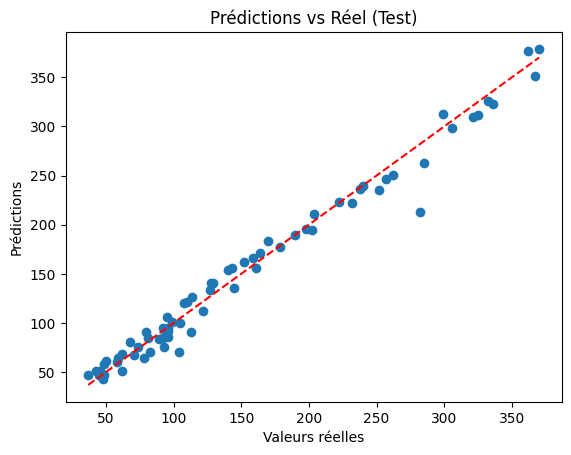

In [48]:
#Visualisation avec nuage de points(scatter plot) valeurs réelles vs prédictions
#creation du scatter plot(x,y):
plt.scatter(y_test, y_test_pred_lr)

# Ajout de titres et de labels:
plt.xlabel("Valeurs réelles")
plt.ylabel("Prédictions")
plt.title("Prédictions vs Réel (Test)")

#Ajout de la ligne de référence (y_test = y_test_pred_lr) où les prédictions égales aux valeurs réelles: 
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')

# Affichage du graphique:  
plt.show()

8. Analyse des Résultats

Analyser les coefficients du modèle pour comprendre l'impact de chaque polluant (feature) sur l'AQI (variable cible).

Chaque coefficient d’un modèle de régression linéaire représente l’effet estimé d’une variable explicative (polluant) sur la variable cible (l’AQI).

In [49]:
# Récupérer les coefficients et l'intercept
coefficients = linear_model.coef_
intercept = linear_model.intercept_                #c'est la valeur prédite de l’AQI quand toutes les variables explicatives sont à zéro

# Associer chaque coefficient à sa variable
coef_df = pd.DataFrame({
    'Variable': features_cols,
    'Coefficient': coefficients
})

# Afficher les résultats
print(f"Intercept : {intercept:.4f}\n")
print("Coefficients du modèle :")
print(coef_df)

Intercept : 11.1898

Coefficients du modèle :
    Variable  Coefficient
0  PM2.5_Avg     0.751033
1   PM10_Avg     0.267372
2    NO2_Avg     0.046121
3    NH3_Avg    -0.000651
4    SO2_Avg     0.064195
5     CO_Avg    -0.002072
6  OZONE_Avg    -0.035897


=> PM2.5_Avg est clairement la variable dominante dans le modèle.

   PM10_Avg a aussi un effet notable.

   Les autres gaz (NO₂, SO₂, NH₃, CO, O₃) ont un effet faible à négligeable selon ce modèle linéaire.

9. Amélioration du Modèle

Réduction des variables pour améliorer un modèle de régression linéaire

Supprimer les variables avec des coefficients proches de zéro (NH3_Avg, CO_Avg, OZONE_Avg) pour simplifier le modèle et réduire le bruit.

In [50]:
# Choisir les variables les plus importantes
selected_features = ['PM2.5_Avg', 'PM10_Avg', 'NO2_Avg', 'SO2_Avg']
label_col = 'AQI'

# Supprimer les lignes manquantes
df = df[selected_features + [label_col]].dropna()

# Séparer X et y
X = df[selected_features]
y = df[label_col]

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Créer et entraîner le modèle réduit
model_reduit = LinearRegression()
model_reduit.fit(X_train, y_train)

# Prédictions
y_train_pred = model_reduit.predict(X_train)
y_test_pred = model_reduit.predict(X_test)

# Évaluation
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
r2_train = r2_score(y_train, y_train_pred)
rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
r2_test = r2_score(y_test, y_test_pred)

# Affichage des performances
print("Modèle réduit (4 variables) — Performances :")
print(f"RMSE (train) : {rmse_train}")
print(f"R²   (train) : {r2_train}")
print(f"RMSE (test)  : {rmse_test}")
print(f"R²   (test)  : {r2_test}\n")

# Affichage des coefficients
print("Coefficients du modèle réduit :")
for feature, coef in zip(selected_features, model_reduit.coef_):
    print(f"{feature} : {coef}")

# Intercept
print(f"\nIntercept : {model_reduit.intercept_}")


Modèle réduit (4 variables) — Performances :
RMSE (train) : 12.718622092130785
R²   (train) : 0.9830415669793697
RMSE (test)  : 14.64376197410745
R²   (test)  : 0.9779307759932838

Coefficients du modèle réduit :
PM2.5_Avg : 0.7483494133742626
PM10_Avg : 0.26108301795781863
NO2_Avg : 0.05101770922260729
SO2_Avg : 0.1757892823153445

Intercept : 9.564168845747332


Le modèle complet a légèrement de meilleures performances (≈ 1 point de RMSE et 0.001 de R²).

Le modèle réduit reste presque aussi performant, mais il est plus simple, plus rapide à exécuter et plus interprétable.

=> garder le modele complet car il a une performance plus stable et légèrement meilleure sur les données de test.

10. catégorisation de l’AQI

La CPCB (autorité indienne) classe l’AQI en 6 catégories avec des plages définies : 0 – 50	Good (Bon) ;  51 – 100 Satisfactory (Satisfaisant) ; 101 – 200 Moderately polluted ; 201 – 300 Poor (Mauvais) ; 301 – 400 Very Poor (Très mauvais) ; 401 – 500 Severe (Sévère)

In [51]:
def categorize_aqi_india(aqi):

    if 0 <= aqi <= 50:
        return "Good"
    elif 51 <= aqi <= 100:
        return "Satisfactory"
    elif 101 <= aqi <= 200:
        return "Moderately polluted"
    elif 201 <= aqi <= 300:
        return "Poor"
    elif 301 <= aqi <= 400:
        return "Very Poor"
    elif 401 <= aqi <= 500:
        return "Severe"
    else:
        return "Beyond Index" # aqi<0 ou aqi>500 hors de l'echelle définie par l'autorité indienne (0 à 500) 
    
#exemple:
    
aqi = -2
categorie = categorize_aqi_india(aqi)
categorie 
print(f"la qualité de l'air est: {categorie}")


la qualité de l'air est: Beyond Index


11. Déploiement du Modèle

deploiement local: Sauvegarde le modele entrainé

In [52]:

import joblib

# Sauvegarde du modèle
joblib.dump(linear_model, 'modele_aqi.pkl')

['modele_aqi.pkl']